In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../3_feature_eng/output/train_feats_double_corr.csv')
train_score = pd.read_csv('../../0_data/train_scores.csv')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats = train_feats[~train_feats['id'].isin(['3e10785d'])]
train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [3]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute",
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies"
# "IWD", "idle", "cursor_visits"
# "intro_punctuation", "body_punctuation", "conclusion_punctuation"
# "intro_aggs", "body_aggs", "conclusion_aggs", "IKI_actual"
# "bursts_v2", "cursor_extra", "counts_v2"




endings_to_keep = ["count_bursts", "word_sent_parag_agg", "intro_punctuation", "body_punctuation", "conclusion_punctuation", "paussed_features",
"intro_aggs", "body_aggs", "conclusion_aggs", "time_feat", "cursor_visits", "IWD", 'cursor_extra', "counts_v2", "pressed_keys", "time_gaps",
"IKI_word", "IKI_actual"]
endings_to_keep += ["id"]




dir_to_save = "lgb24"
stratification = True
n_jobs = -1
noise = True
data_augmentation = False

iterations = 1
n_splits = 3


try:
    os.mkdir(dir_to_save)
except:
    print('Already exists')
    sys.exit()

# cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]
cols_to_keep = [col for col in train_feats.columns if any(ending in col for ending in endings_to_keep) or col in ['id', 'score']]
# cols_to_keep = manual_list + ['id', 'score']

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

607


In [4]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [5]:
with open(f'{dir_to_save}/new_col_dict.pkl', 'wb') as f:
    pickle.dump(new_columns, f)

In [6]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [7]:
def data_augmentation(x, y, pct=0.75, scale=0.05):
    # Determine the number of rows to create
    num_rows = x.shape[0]
    num_new_rows = int(num_rows * pct)

    # Randomly select rows from the original DataFrame
    indices = np.random.choice(x.index, size=num_new_rows)
    new_rows_x = x.loc[indices]

    # Add Gaussian noise to each numerical column
    for col in new_rows_x.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(loc=0.0, scale=scale, size=num_new_rows)
        new_rows_x[col] += new_rows_x[col] * noise

    # Append the new rows to the original DataFrame
    x = pd.concat([x, new_rows_x], ignore_index=True)

    # Do the same for y
    new_rows_y = y.loc[indices]
    y = pd.concat([y, new_rows_y], ignore_index=True)

    return x, y

In [8]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41, data_augmentation=False, noise=True):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1), #trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1), #trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_float('subsample', 0.5, 1),# trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20]),
        'num_leaves': trial.suggest_int('num_leaves', 9, 30, step=3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1400, step=100),
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": n_jobs,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    if data_augmentation:
        train_x, train_y = data_augmentation(train_x, train_y, pct=0.75, scale=0.05)
    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)

    model.fit(train_x, train_y)
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)
    
    return rmse

In [9]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, noise=False, data_augmentation=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1,RANDOM_STATE,data_augmentation), n_trials=15)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": n_jobs,
        **best_trial1
    }
        
    model = lgb.LGBMRegressor(**best_params)
    if data_augmentation:
        x_train, y_train = data_augmentation(x_train, y_train, pct=0.75, scale=0.05)
    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)
    model.fit(x_train, y_train)
    model.booster_.save_model(f'./{dir_to_save}/lgb_iter{iter}_split{split}_val1.txt')

    # Predict on v2
    valid2_predict = model.predict(x_valid2)


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE,data_augmentation), n_trials=15)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": n_jobs,
        **best_trial2
    }
        
    model = lgb.LGBMRegressor(**best_params)
    if data_augmentation:
        x_train, y_train = data_augmentation(x_train, y_train, pct=0.75, scale=0.05)
    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)
    model.fit(x_train, y_train)
    model.booster_.save_model(f'./{dir_to_save}/lgb_iter{iter}_split{split}_val2.txt')

    # Predict on v1
    valid1_predict = model.predict(x_valid1)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [10]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1


for i in range(iterations):

    if stratification:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats, score_transformed)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, noise=noise, data_augmentation=data_augmentation)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

    else:
        kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, noise=noise, data_augmentation=data_augmentation)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

[I 2024-01-08 18:42:42,083] A new study created in memory with name: no-name-98f19b9e-996e-472e-ac52-ef30969c78f1


[I 2024-01-08 18:42:45,397] Trial 0 finished with value: 0.6153310934262177 and parameters: {'reg_lambda': 0.21076305628230776, 'reg_alpha': 0.013181563587555099, 'colsample_bytree': 0.6089121826138528, 'colsample_bynode': 0.9798358040190343, 'subsample': 0.5261224345131515, 'learning_rate': 0.03857219899032652, 'max_depth': 17, 'min_child_samples': 9, 'num_leaves': 22, 'n_estimators': 300}. Best is trial 0 with value: 0.6153310934262177.
[I 2024-01-08 18:42:55,481] Trial 1 finished with value: 0.6975331712371652 and parameters: {'reg_lambda': 0.3775255305765189, 'reg_alpha': 0.015295729112917354, 'colsample_bytree': 0.7596778330008063, 'colsample_bynode': 0.957712129732879, 'subsample': 0.6194362705264654, 'learning_rate': 0.0008728113616221941, 'max_depth': 7, 'min_child_samples': 17, 'num_leaves': 14, 'n_estimators': 1300}. Best is trial 0 with value: 0.6153310934262177.
[I 2024-01-08 18:42:59,419] Trial 2 finished with value: 0.6335216629721112 and parameters: {'reg_lambda': 9.0114

In [11]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric LGBM = 0.62826


In [12]:
import pickle

with open(f'{dir_to_save}/OOF_base_lgb.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE, f)

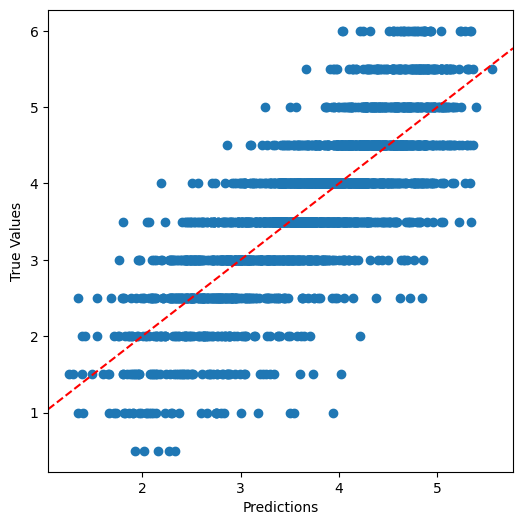

In [13]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

In [14]:
len(OOF_SCORE)

2470

In [15]:
sum(OOF_SCORE <= 2)

60

In [16]:
sum(train_feats['score'] <= 2)

200